# Spectral Differentiation of Periodic Functions

Spectral methods are a class of numerical techniques for solving differential equations by expanding the solution in terms of global basis functions, typically trigonometric functions (for periodic problems) or orthogonal polynomials (e.g, Chebyshev polynomials). This approach can achieve extremely high accuracy with relatively function points, particularly when the function is smooth.

In the case of **periodic functions**, spectral differentiation is typically carried out using the **Fourier basis**. Given a periodic function sampled at equispaced points, the derivative can be efficiently computed via the **Fast Fourier Transform (FFT)**. The main idea is to:
1. Transform the function to the frequency domain $u \to \hat{u}$.
2. Differentiate in the frequency domain by multiplying each mode by its wavenumber $\hat{v}_k = \frac{d}{dx} \hat{u}_k = ik \cdot \hat{u}_k$.
3. Transform back to the physical domain $u' \approx \hat{v} \to v$.

This approach is referred to as **Fourier spectral differentiation**.

#### Benefits

- **High accuracy**: For smooth, periodic functions, spectral methods exhibit **exponential convergence**—the error decreases faster than any power of the grid spacing.
- **Efficiency**: By using the FFT, spectral differentiation is computationally efficient, with $ O(n\log n) $ complexity.
- **Compact representation**: Spectral coefficients often decay rapidly, enabling compact storage and manipulation.

#### Drawbacks

- **Restriction to periodic domains**: Fourier spectral methods assume periodic boundary conditions. Applying them to non-periodic problems often introduces artifacts unless the problem is reformulated (usually what is done to use Chebyshev polynomials).
- **Global nature**: Spectral basis functions are global, meaning that local changes in the solution affect the entire domain, making adaptivity and handling discontinuities difficult.
- **Aliasing and Gibbs phenomena**: Non-smooth functions can suffer from oscillations and loss of accuracy due to high-frequency mode contamination.

### Fourier Interpolant and Connection to FFT/IFFT

Given a $[0, 2\pi]$ periodic function $u(x)$, sampled at $N$ **equispaced points** on the interval $[0, 2\pi)$, we define the grid as:

$$
x_j = \frac{2\pi j}{N}, \quad j = 0, 1, \dots, N-1
$$

These points are **uniformly spaced**, with spacing $h = x_{j+1} - x_j = \frac{2\pi}{N}$.

We define the **Fourier interpolant** $p(x)$ as a trigonometric polynomial that matches the values $ u_j = u(x_j) $ at the grid points. It is given by:

$$
p(x) = \frac{1}{2\pi} \sum_{k = -N/2}^{N/2} \hat{u}_k \, e^{2\pi ikx}
$$

where $\hat{u}_k$ are the **Fourier coefficients**, computed as:

$$
\hat{u}_k = \sum_{j=0}^{N-1} u_j \, e^{- 2\pi ikx_j}, \quad \text{for } k = -N/2, \dots, N/2
$$


#### FFT and IFFT

- **FFT** (Fast Fourier Transform) computes the coefficients $\hat{u}_k$ efficiently from the data $\{u_j\}_{j = 0}^{N-1}$.
- **IFFT** (Inverse FFT) reconstructs the values or interpolant $p(x)$ at the grid points from the Fourier coefficients.

This process allows efficient interpolation and differentiation of periodic functions.




# Examples of Spectral Differentiation of Periodic Functions


In [3]:
using LinearAlgebra
using PlotlyJS
using FFTW
using BenchmarkTools
using Kronecker

WebIO._IJuliaInit()

1.
$$
u(x) = \exp(\sin(x)),  \quad \text{for } x \in [0, 2\pi)
$$
and we will compare the spectral derivative to its associated first derivative
$$
u'(x) = \cos(x) \exp(\sin(x)) = \cos(x) u(x),  \quad \text{for } x \in [0, 2\pi)
$$

In [187]:
N = 64 # number of points
h = 2 * pi/N # stepsize
x = h * collect(0:N-1) # domain
u = exp.(sin.(x)); # function

In [188]:
# First, we find its fft (Fourier coefficients)
u_hat = fft(u);

In [189]:
# After that, we compute its spectral derivative
v_hat = 1im * (vcat(0:N÷2 - 1, 0, -N÷2 + 1:-1)) .* u_hat; 

In [190]:
# Finally, we compute the ifft to return from the frequency to the physical space
# We will consider only the real part since it f:R->R function
v = real(ifft(v_hat));

In [191]:
# Now, we compare this spectral derivative with the analytical derivative
du_dx = cos.(x) .* u;

In [192]:
# We compute the L_inf error norm between the two derivatives
error = norm(du_dx-v, Inf)/norm(du_dx, Inf)

6.559044768410425e-15

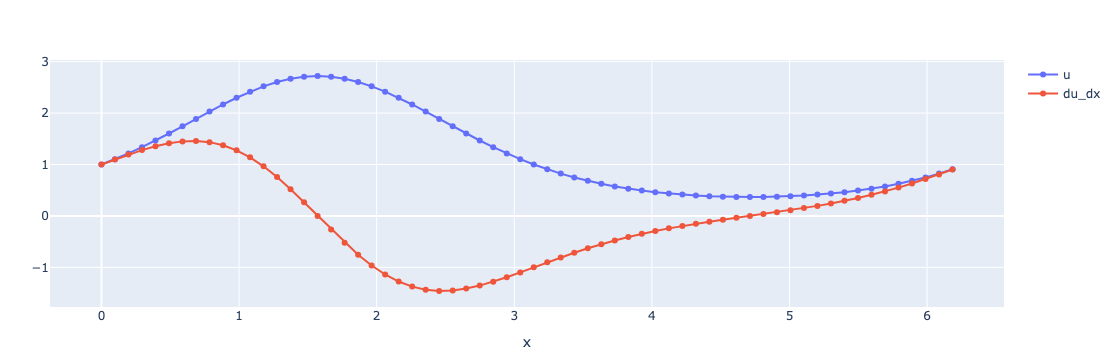

In [193]:
# Also, we will plot the function, its derivative and the residual = du_dx - v
plot([
    scatter(x=x, y=u, mode="markers+lines", name="u"),
    scatter(x=x, y=du_dx, mode="markers+lines", name="du_dx")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)


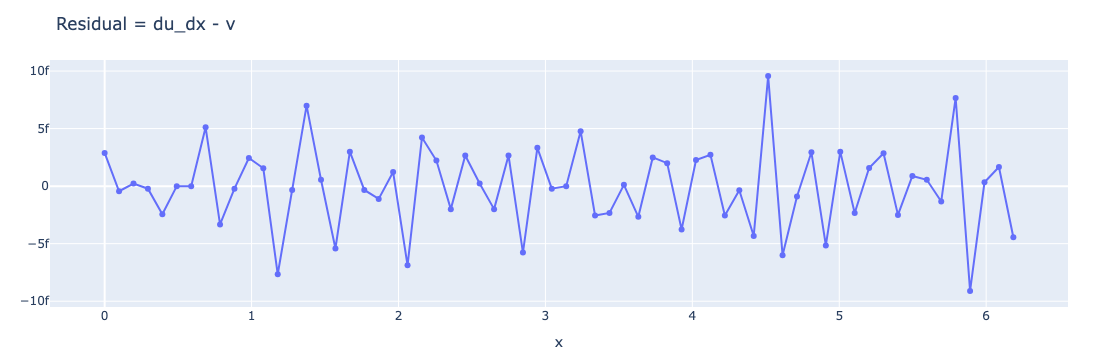

In [194]:
plot([
    scatter(x=x, y=du_dx - v, mode="markers+lines")],
    Layout(xaxis_title="x", title="Residual = du_dx - v") #yaxis_title="u(x)",  
)

2.
$$
u(x) = \left[\sin^{2}\left(\frac{1}{2}\pi x\right)\right]^{\frac{3}{4}}$$



Unlike our previous function, this function is not $C^{\infty}$. While we can still use spectral differentiation, this reduces the quality of the approximations. Let's start plotting $u(x)$ first.

In [195]:
N = 64 # number of points
h = 2 * pi/N # stepsize
x = h * collect(0:N-1) # domain
u = ((sin.(1/2 * pi * x)).^2).^(3/4); # function

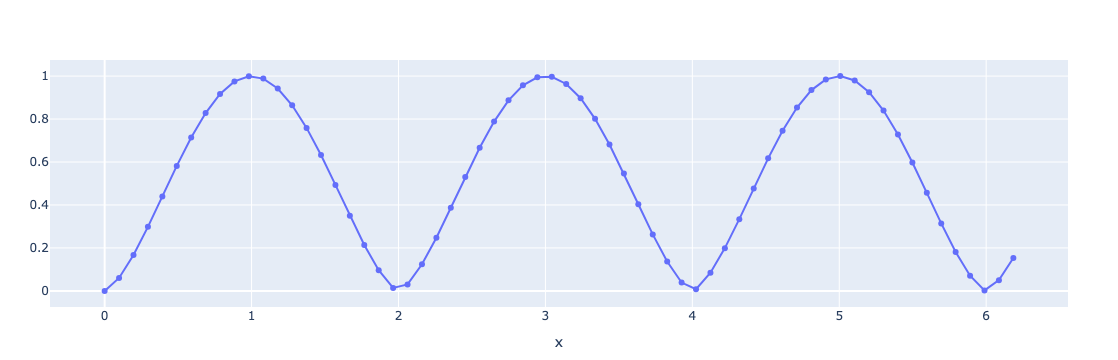

In [196]:
plot([
    scatter(x=x, y=u, mode="markers+lines", name="u")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)

We first notice that the function is periodic in $[0, 2)$. In order to perform spectral derivative, we may consider: 

$$
u(x(z)) = \left[\sin^{2}\left(\frac{1}{2}\pi x(z)\right)\right]^{\frac{3}{4}}$$

in which $x(z) = \frac{2}{2\pi}z.$

Thus, with respect $z$, this function is periodic in $[0, 2\pi)$

In [197]:
N = 64 # number of points
z = h * collect(0:N-1) # domain
x = 1/pi * z
u = ((sin.(1/2 * pi * x)).^2).^(3/4); # function

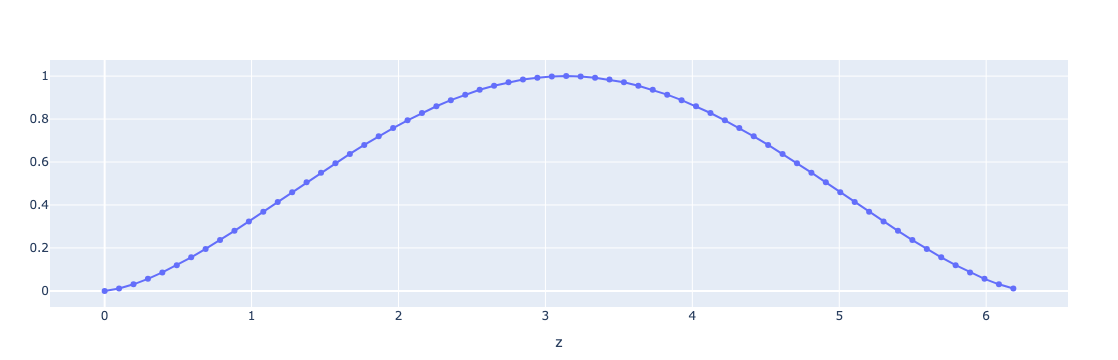

In [198]:
plot([
    scatter(x=z, y=u, mode="markers+lines", name="u")],
    Layout(xaxis_title="z") #yaxis_title="u(x)",  
)

Now, we may try to compute $\frac{du}{dx}$. We know that 

$$\begin{align*}
\frac{d}{dz} u(x(z)) = \frac{du}{dx} \frac{dx}{dz}
\end{align*}
$$
in which

$$
\frac{du}{dx} = \frac{3\pi}{4} \left(\sin\left(\frac{\pi x}{2}\right)\right)^{\frac{1}{2}} \cos\left(\frac{\pi x}{2}\right)
$$
$$
\frac{dx}{dz} = \frac{1}{\pi}
$$

If spectral differentation computes $\frac{d}{dz} u(x(z))$, we just need to compute $\frac{du}{dx} = \left( \frac{dx}{dz} \right)^{-1} \frac{d}{dz} u(x(z)) = \pi \cdot \frac{d}{dz} u(x(z)).$

In [199]:
# Finding fourier coefficients (or moving to frequency domain)
u_hat = fft(u);

In [200]:
# After that, we compute its spectral derivative
v_hat = 1im * (vcat(0:N÷2 - 1, 0, -N÷2 + 1:-1)) .* u_hat; 

In [201]:
# Finally, we compute the ifft to return from the frequency to the physical space
# We will consider only the real part since it f:R->R function
v = real(ifft(v_hat));

In [202]:
# Finding du/dx = (dx/dz)^-1 * d/dz u(x(z)) 
dx_dz = 1/pi
v = v * (dx_dz)^(-1);

In [203]:
# Computing analytical derivative on domain
du_dx = (3 * pi / 4) * sqrt.(sin.(pi * x / 2)) .* cos.(pi * x / 2);

In [204]:
# We compute the L_inf error norm between the two derivatives
error = norm(du_dx-v, Inf)/norm(du_dx, Inf)

0.038261343072240925

We notice that the error is much larger this time, since $u(x)$ is not as smooth as the previous example. 

*It is worth mentioning that, if we consider the wavelength to be $\hat{k} = \frac{2\pi k}{L}$, then it is not necessary to rescale the problem domain.*

# Solution of differential equations

We may use the concept of spectral differentiation to solve differential equations. For example, the 1D Poisson equation with periodic BCs:

$$
\begin{align*}
-u''(x) = f(x)&, \quad x\in[0, 2\pi] \\ 
\begin{cases}&u(0) = u(2\pi) \\
&u'(0) = u'(2\pi)
\end{cases}
\end{align*}
$$

It is necessary that $$\frac{1}{2\pi}\int_{0}^{2\pi}f(x) dx = 0,$$ since

$$\frac{1}{2\pi}\int_{0}^{2\pi}f(x) dx= -\frac{1}{2\pi}\int_{0}^{2\pi}u''(x) dx = -\frac{1}{2\pi}(u'(2\pi) - u'(0)) = 0.$$

Our first example will be $f(x) = \cos(x) - \cos(3x)$. Thus, the analytical solution is $u(x) = \cos(x) - \frac{1}{9}\cos(3x)$.

In [205]:
using QuadGK;

In [206]:
# Checking if satisfies the condition
f(x) = cos(x) - cos(3 * x)
result, err = quadgk(f, 0, 2*pi)

(2.991419572420751e-14, 4.8197776865144034e-18)

In order to solve this differential equation, we may compute the DFT (with FFT) at both sides of the ODE:

$$-\hat{u}''_k = \hat{f}_k, \quad \text{for }k = -N/2, ..., N/2.$$

Moreover, using the results from spectral differentation, 
$$\hat{u}''_k= (ik)^2 \hat{u}_k \to  \hat{u}_k = -\frac{\hat{u}''_k}{k^2} = \frac{f_k}{k^2}.$$

After finding $\hat{u}_k$, we may use the inverse DFT (with IFFT) to obtain the solution $u_k$.


In [207]:
# Number of grid points
N = 64
L = 2 * pi
h = L/N # stepsize
x = h * collect(0:N-1) # domain


# Define RHS function
f_rhs = cos.(x) .- cos.(3 * x)

# FFT of RHS
f_hat = fft(f_rhs)

# Wavenumbers (assumes 2π-period)
k = vcat(0:N÷2, -N÷2+1:-1)

# Solve in Fourier space: u_hat = f_hat / k^2
u_hat = copy(f_hat) 
u_hat[2:end] = u_hat[2:end] ./ (k[2:end].^2)   

# Inverse FFT to get back to physical space
u = real(ifft(u_hat));

In [208]:
u_exact(x) = cos(x) - cos(3 * x)/9 ;

In [209]:
# Finding error
error = norm(u_exact.(x) - u, Inf)/norm(u_exact.(x), Inf)

6.245004513516506e-16

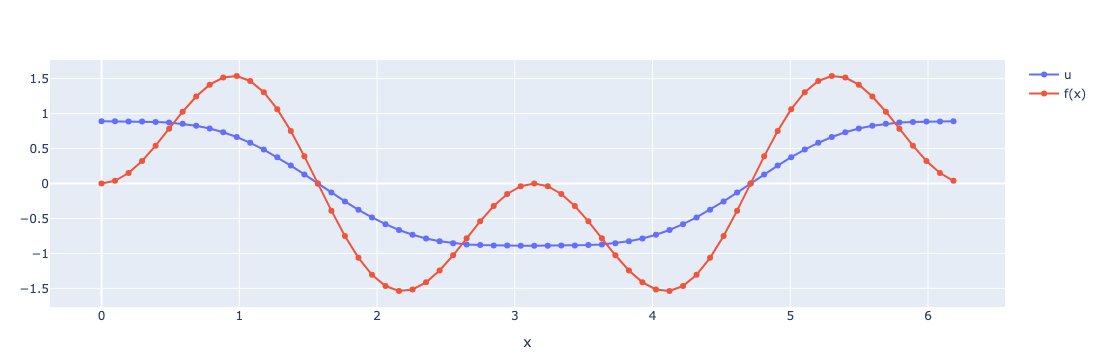

In [210]:
plot([
    scatter(x=x, y=u, mode="markers+lines", name="u"),
    scatter(x=x, y=f_rhs, mode="markers+lines", name="f(x)")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)

The condition $$\frac{1}{2\pi}\int_{0}^{2\pi}f(x) dx = 0$$ certainly limits the possibilities of solving differential equations with this approach. It is possible to circumvent this limitation by subtracting the mean and adding it after the solution is obtained.
Assume we solve another Poisson problem (Dirchlet homogeneous BCs):

$$f(x) = \cos(x) + \cos(2x) + \exp(\sin(x)).$$

$$
\begin{align*}
-u''(x) = f(x)&, \quad x\in[0, 2\pi] \\ 
\begin{cases}&u(0) = u(2\pi) = 0  \end{cases}
\end{align*}
$$

Since the term $\int_{0}^{2\pi}\exp(\sin(x))dx \neq 0$, $u'(0) \neq u'(2\pi)$, and if the same approach is employed, it is necessary to consider an alternate problem: 

$$
\begin{align*}
-u_{\text{zero}}''(x) = f_{\text{zero}}(x)&, \quad x\in[0, 2\pi] \\ 
\begin{cases}&u_{\text{zero}}(0) = u_{\text{zero}}(2\pi) \\
&u_{\text{zero}}'(0) = u_{\text{zero}}'(2\pi)
\end{cases}
\end{align*}
$$
in which $f_{\text{zero}}(x) = f(x) - \frac{1}{2\pi}\int_{0}^{2\pi}f(x)dx = f(x) - \mu_f.$

We will approximate $\mu_f$ in our grid as $\frac{1}{N}\sum_{j=1}^N f(x_j)$.

In [211]:
# Number of grid points
N = 200
L = 2 * pi
h = L/N # stepsize
x = h * collect(0:N-1) # domain

# Define RHS function
f_rhs = cos.(x) + cos.(2 * x) + exp.(sin.(x))

# Finding f_zero
μ_f = mean(f_rhs)
f_zero = f_rhs .- μ_f 

# FFT of RHS
f_hat = fft(f_zero)

# Wavenumbers (assumes 2π-period)
k = vcat(0:N÷2, -N÷2+1:-1)

# Solve in Fourier space: u_hat = f_hat / k^2
u_hat = copy(f_hat) 
u_hat[2:end] = u_hat[2:end] ./ (k[2:end].^2)   

# Inverse FFT to get back to physical space
u_zero = real(ifft(u_hat));

Now, we obtained a solution $u_\text{zero}(x)$, which is not the solution itself $u(x)$.

We notice that, by integrating $-u''_\text{zero}(x) = f_{\text{zero}}(x)$ twice from $0$ to $x$:
$$\begin{align*}
-u_\text{zero}(x) = -u(x) - \mu_f \frac{x^2}{2} - C_0x - C_1\\ u(x) = u_\text{zero}(x) - \mu_f \frac{x^2}{2} + C_0x + C_1. 
\end{align*}$$

For $u(0) = 0$,
$$\begin{align*}
u_\text{zero}(0) + C_1 = 0 \to C_1 = -u_\text{zero}(0).
\end{align*}$$
As for $u(2\pi) = 0$,
$$\begin{align*}
u_\text{zero}(2\pi) - \mu_f \frac{(2\pi)^2}{2} + C_0 \cdot 2\pi -u_\text{zero}(0) = 0 \\
C_0 = \frac{1}{2\pi} (u_\text{zero}(0) - u_\text{zero}(2\pi) - \mu_f 2\pi^2) =  -\mu_f \pi.
\end{align*}
$$

In [212]:
# Recovering u from u_zero
c_1 = -u_zero[1]
c_0 = μ_f * pi
u_fft = u_zero - μ_f/2 * x.^2 + c_0 * x .+ c_1;

Since the term $\exp(\sin(x))$ does not have an antiderivative expressed in terms of elementary functions, we will instead compare the second derivative of $u$ along the grid (using finite difference formulas) and the exact $f(x)$ given in the differential equation.

In [213]:
function second_derivative_fd(u, dx)
    N = length(u)
    d2u = zeros(N)

    # Interior points: centered 3-point stencil
    for i in 2:N-1
        d2u[i] = (u[i+1] - 2 * u[i] + u[i-1]) / dx^2
    end

    # Left endpoint: 5-point forward difference
    d2u[1] = (35/12 * u[1] - 26/3 * u[2] + 19/2 * u[3] − 14/3 * u[4] + 11/12 * u[5]) / dx^2

    # Right endpoint: 5-point backward difference
    d2u[end] = (35/12 * u[end] - 26/3 * u[end-1] + 19/2 * u[end-2] − 14/3 * u[end-3] + 11/12 * u[end-4]) / dx^2

    return d2u
end


second_derivative_fd (generic function with 1 method)

In [214]:
d2u_fd = second_derivative_fd(u_fft, h)
abs_error = norm(-d2u_fd - f_rhs, Inf)

0.00036189218138216184

In [215]:
h, h^2

(0.031415926535897934, 0.0009869604401089359)

The absolute error $\|-u_{\text{FDiff}}'' - f\|_{\infty} $ is of order $O(h^2)$, which agrees with the finite difference approximation theory.


In [216]:
error = abs_error/norm(f_rhs, Inf)

0.00011572276492521297

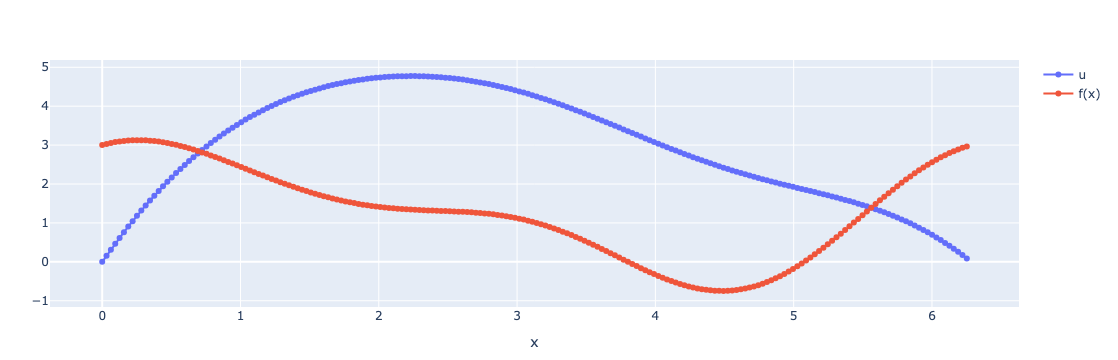

In [217]:
plot([
    scatter(x=x, y=u_fft, mode="markers+lines", name="u"),
    scatter(x=x, y=f_rhs, mode="markers+lines", name="f(x)")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)

Instead of the Fourier basis, other trigonometric basis may be used to solve ODEs/PDEs. For example, the Discrete Sine Transform is suitable for the Poisson problem with Dirichlet boundary conditions. Let us see how this is done:

##  Discrete Sine Transform Type-I (DST-I) for Poisson Problems

We aim to solve the 1D Poisson problem:

$$
-u''(x) = f(x), \quad x \in (0, L), \quad u(0) = u(L) = 0.
$$

A convenient approach is to expand the solution using a **sine series**, which automatically satisfies the zero boundary conditions.

---

###  Grid and Sine Expansion

We discretize the domain using **interior points only** (excluding the boundaries):

$$
x_j = \frac{jL}{N+1}, \quad j = 1, 2, \dots, N
$$

At these points, we approximate the solution $u(x_j)$ by a sine expansion:

$$
u(x_j) \approx  \sum_{k=1}^{N} \hat{u}_k \sin\left(\frac{\pi k x_j}{L} \right) =  \sum_{k=1}^{N} \hat{u}_k \sin\left(\frac{\pi k j}{N+1} \right)
$$

This defines the **Discrete Sine Transform of Type-I (DST-I)**.

---

### How DST-I Helps

The sine basis functions are eigenfunctions of the second derivative with homogeneous Dirichlet BCs. So if we write:

$$
u(x) = \sum_{k=1}^\infty \hat{u}_k \sin\left(\frac{\pi k x}{L}\right)
$$

then applying the second derivative gives:

$$
u''(x) = - \left( \frac{\pi k}{L} \right)^2 \sum_{k=1}^\infty \hat{u}_k  \sin\left(\frac{\pi k x}{L}\right) = -\left( \frac{\pi k}{L} \right)^2 u(x).
$$

We will work with a finite number of frequencies along the grid.
To solve $-u''(x_j) = f(x_j)$, we will:

1. Apply DST-I to $f_j = f(x_j)$ to get $\hat{f}_k$
2. Solve $\hat{u}_k = \hat{f}_k$ $\left( \frac{\pi k}{L} \right)^{-2} $
3. Invert DST-I to recover $u_j$

---

### DST-I via FFT (Extension Method)

DST-I can be computed via FFT using an **odd extension** of the data. Here's how:

Let
$$
u = [u_1, u_2, \dots, u_N]
$$  
be a vector of function values $u_j = u(x_j)$ corresponding to the **interior points** of a domain $x \in [0, L]$, with spacing $h = \frac{L}{N+1}$. 

Since $u$ only contains interior values, we must extend it in a way that respects the **Dirichlet BCs**. This is done by creating an **odd extension** of the data.

We define the odd extension as:

$$
u_{\text{ext}} = [0, u_1, u_2, \dots, u_N, 0, -u_N, -u_{N-1}, \dots, -u_1]
$$

This gives a vector of length $2(N+1)$, and enforces:

- $u_{\text{ext}}[0] = 0$
- $u_{\text{ext}}[N+1] = 0$
- Odd symmetry: $u_{\text{ext}}[x] = -u_{\text{ext}}[N + 1-x]$

### Why Add Zeros?

The zeros at the start and middle of the extended array **explicitly encode the boundary conditions** $u(0) = u(L) = 0$. By doing so, the extended function naturally satisfy homogeneous Dirichlet BCs after a sine transform.

By extending the data oddly and ensuring zeros at the boundaries, the extended function becomes purely **odd**, meaning its Fourier transform contains only **sine terms**. Taking the **imaginary part** of the FFT over this extended data isolates these sine components, effectively computing the DST-I.

### Summarizing the procedure.

1. Given $u \in \mathbb{R}^N$, extend it to an **odd** array of length $2(N+1)$
2. Compute FFT of this array
3. Extract the imaginary parts of appropriate entries.






In [218]:
N = 10
u = randn(N);

In [219]:
# Function to perform DST-I via FFT using odd extension
function dst1_fft(f)
    N = length(f)
    
    # Fill odd extension
    f_ext = vcat([0], f, [0], -reverse(f))

    # Apply FFT and take imaginary part (odd part)
    F_ext = fft(f_ext)
    dst = -imag(F_ext[2:N+1])  # Extract DST-I components 
    
    return dst
end

function idst1_fft(f_hat)
    N = length(f_hat)
    
    # Fill odd imaginary extension
    F_ext = vcat([0], -1im * f_hat, 0, 1im * reverse(f_hat))
    
    # Inverse FFT and extract
    f_ifft = real(ifft(F_ext))
    idst = f_ifft[2:N+1]
    return idst
end

idst1_fft (generic function with 1 method)

In [220]:
norm(idst1_fft(dst1_fft(u)) - u, Inf)/norm(u, Inf)

1.4412175193453247e-16

We may now solve the 1D Poisson problem 
$$
-u''(x) = f(x), \quad x \in (0, L), \quad u(0) = u(L) = 0
$$
using DST. We will use $L = 2\pi$ , $f(x) = \cos(x) + \cos(2x) + \exp(\sin(x))$ as in the previous example.

In [221]:
# Parameters
N = 199
L = 2 * pi
h = L / (N + 1)
x = h * collect(1:N)

# RHS
f_rhs = cos.(x) .+ cos.(2x) .+ exp.(sin.(x))

# DST-I of RHS
f_hat = dst1_fft(f_rhs)

# Spectral solve
k = collect(1:N) 
u_hat = f_hat .* (pi * k / L).^(-2)

# Inverse DST-I
u_dst = idst1_fft(u_hat);

# To compare with the solution obtained with FFT, we will add u(0) = 0
u_dst = vcat([0], u_dst);

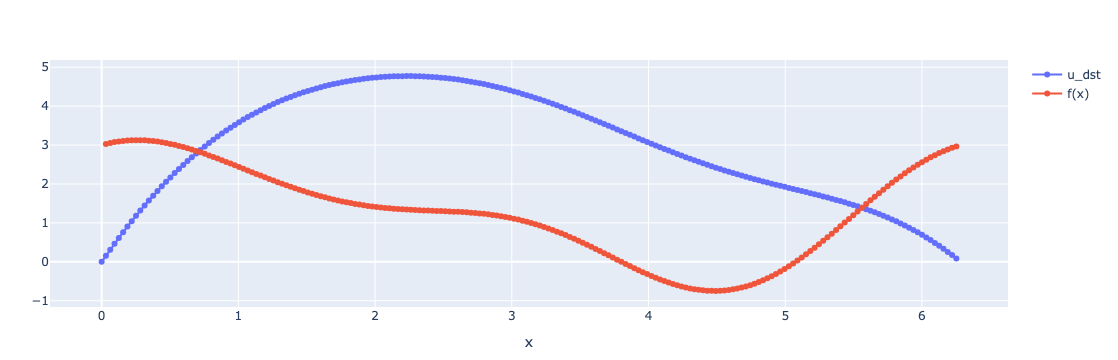

In [222]:
plot([
    scatter(x=vcat([0],x), y=u_dst, mode="markers+lines", name="u_dst"),
    scatter(x=x, y=f_rhs, mode="markers+lines", name="f(x)")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)

In [223]:
error = norm(u_dst - u_fft, Inf)/norm(u_dst, Inf)

5.552659395988035e-5

Similarly, for Neumann BCs, we may use a basis of cosine, which leads to the Discrete cosine Transform.


We aim to solve the 1D Poisson problem:

$$
-u''(x) = f(x), \quad x \in (0, L), \quad u'(0) = u'(L) = 0.
$$

A convenient approach is to expand the solution using a **cosine series**, which automatically satisfies the zero neumann boundary conditions.

---

## Discrete Cosine Transform Type-I (DCT-I) for Poisson Problems

Just like the **DST-I** represents a function using **sine functions** (odd extensions), the **DCT-I** represents a function using **cosine functions** (even extensions). Here's how it works:

---

### DCT-I Expansion

Given a function $u(x)$ defined on $x \in [0, L]$, and sampled at **interior grid points**:
$$
x_j = \frac{L j}{N+1}, \quad j = 1, 2, \dots, N
$$


The **DCT-I** expansion is:

$$
u(x_j) \approx \sum_{k=1}^{N} \hat{u}_k \cos\left( \frac{\pi (k-1) x_j}{L} \right) = \sum_{k=1}^{N} \hat{u}_k \cos\left( \frac{\pi (k-1) j}{N+1} \right)
$$

where:


- $\hat{u}_k$ are the **DCT-I coefficients**, given by:

$$
\hat{u}_k = \sum_{j=1}^{N} u_j \cos\left( \frac{\pi (k-1) j}{N+1} \right)
$$

up to normalization constants depending on the convention.

---

We may compute the DCT-I similarly to DST-I using the **FFT**, by performing an **even extension** of the data:

Let $u = [u_1, u_2, \dots, u_N] $ be the input data (samples at interior grid points), then define the even extension:

$$
u_{\text{ext}} = [u_1, u_2, \dots, u_N, u_{N-1}, \dots, u_2]
$$


Finally, extract the first $N$ **real** components to get the DCT-I coefficients.

This works because the even extension ensures the resulting complex Fourier transform only contains real components in the cosine terms, which matches the DCT-I basis.





In [224]:
function dct1_fft(f)
    N = length(f)
    # Construct even extension (DCT-I symmetry: f[-k] = f[k], f[N+k] = f[N-k])
    f_ext = vcat(f, f[end-1:-1:2])  

    # Compute FFT (scaling handled later)
    F_ext = fft(f_ext)

    # Extract first N coefficients (real part)
    dct = real(F_ext[1:N])

    return dct
end

function idct1_fft(f_hat)
    N = length(f_hat)
    # Construct even-symmetric extension in frequency domain
    F_ext = vcat(f_hat, f_hat[end-1:-1:2])

    # Compute inverse FFT and take real part
    f_ifft = real(ifft(F_ext))

    # Extract the first N samples (original signal)
    idct = f_ifft[1:N]

    return idct
end

idct1_fft (generic function with 1 method)

In [225]:
# Parameters
N = 200
L = 2 * pi
h = L / (N + 1)
x = h * collect(1:N)

# RHS (same as before f(x) = cos(x) + cos(2x) + exp(sin(x)))
f_rhs = cos.(x) .+ cos.(2x) .+ exp.(sin.(x))

# DCT-I of RHS
f_hat = dct1_fft(f_rhs)  

# Spectral solve for Poisson equation
k = 0:(N-1)  # DCT-I frequencies
u_hat = zeros(N)
u_hat[2:N] = -f_hat[2:N] .* (pi/L * k[2:N]).^(-2)  


# Inverse DCT-I to get solution u(x)
u_dct = idct1_fft(u_hat); 

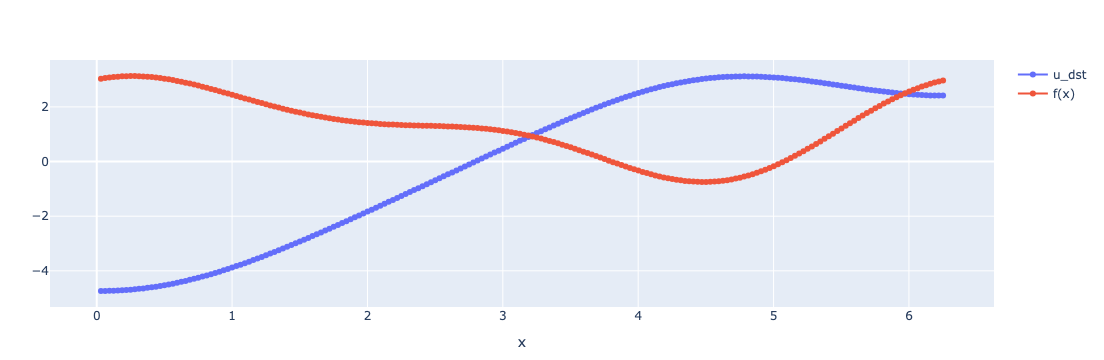

In [226]:
plot([
    scatter(x=x, y=u_dct, mode="markers+lines", name="u_dst"),
    scatter(x=x, y=f_rhs, mode="markers+lines", name="f(x)")],
    Layout(xaxis_title="x") #yaxis_title="u(x)",  
)

# 2D Laplacian problem 

**TO DO: Explanation**

$$-\nabla^2 u = f(x, y), \quad \text{for } (x,y) \in [0, L_x] \times [0, L_y]$$
$$f(x, y) = \cos(x) \sin(y)$$


periodic BCs for both $x$ and $y$.

Analytical solution $u(x, y) = \frac{1}{2} \cos(x) \sin(y) = \frac{1}{2}f(x,y)$.

2D FFT

$$
\hat{u}_{p,q} =  \sum_{q=0}^{n_y-1} \sum_{p=0}^{n_x-1} u_{p,q} \, \exp(-2\pi i\left(x_p + y_q \right)) =  \sum_{q=0}^{n_y-1} \sum_{p=0}^{n_x-1} u_{p,q} \, \exp\left(-2\pi i\left[\frac{k_x p}{n_x} + \frac{l_j q}{n_y} \right] \right), \quad \text{for } k_x = ..., k_y = ...
$$



# 2D Poisson Equation (Periodic BCs) using FFT 

We now want to solve the 2D Poisson problem:

$$
- \nabla^2 u(x, y) = f(x, y), \quad \text{with } u(x, y) \text{ periodic in both } x \text{ and } y,
$$

on the rectangular domain $[0, L_x) \times [0, L_y)$, with a given right-hand side:

$$
f(x, y) = \cos(x) \sin(y)
$$

The **analytical solution** is:

$$
u(x, y) = \frac{1}{2} \cos(x) \sin(y) = \frac{1}{2}f(x, y)
$$

---

### Basic Idea

As we already know Fourier basis functions are complex exponentials. For the 2D case, it is $e^{i(k_x x + k_y y)}$. Its second derivative has
same property observed in the 2D case.

$$
\frac{d^2}{dx^2} e^{i k_x x} = -k_x^2 e^{i k_x x}, \quad \frac{d^2}{dy^2} e^{i k_y y} = -k_y^2 e^{i k_y y}
$$

So, when we apply the Laplacian $\nabla^2$ in the frequency domain, it turns into **simple multiplication** (in other words, the 2D DFT diagonalizes the operator):

$$
\widehat{(-\nabla^2 u)}(k_x, k_y) = (k_x^2 + k_y^2) \hat{u}(k_x, k_y)
$$

Thus, we may use the same strategy as in the 1D cases:

1. Apply 2D FFT over $f(x, y)$,
2. Divide each mode by $k_x^2 + k_y^2$,
3. Apply 2D IFFT to obtain solution.

---

### 2D FFT 

Let $u_{p,q} \approx u(x_p, y_q)$ with:

* $x_p = \frac{p L_x}{n_x},\quad p = 0, \dots, n_x - 1$
* $y_q = \frac{q L_y}{n_y},\quad q = 0, \dots, n_y - 1$

Then the 2D **Discrete Fourier Transform (DFT)** is:

$$
\hat{u}_{k_x, k_y} = \sum_{q=0}^{n_y - 1} \sum_{p=0}^{n_x - 1} u_{p,q} \cdot \exp\left( -2\pi i \left[ \frac{k_x p}{n_x} + \frac{k_y q}{n_y} \right] \right)
$$

Here:

* $k_x \in \left[0, 1, \dots, \left\lfloor \frac{n_x}{2} \right\rfloor, -\left\lfloor \frac{n_x}{2} \right\rfloor+1, \dots, -1\right]$
* $k_y \in \left[0, 1, \dots, \left\lfloor \frac{n_y}{2} \right\rfloor, -\left\lfloor \frac{n_y}{2} \right\rfloor+1, \dots, -1\right]$

---

### How to compute the 2D FFT 

Although we refer to it as a "2D FFT," the computation is actually done by applying **1D FFTs twice**:

1. **First along one axis (e.g. rows)** — each row is treated as a 1D signal and transformed using a 1D FFT.
2. **Then along the other axis (e.g. columns)** — the result from step 1 is then transformed column-wise with a 1D FFT again.

This works because the 2D DFT is **separable**, meaning it can be written as a product of two 1D DFTs.
It is worth mentioning that using JuliaFW's internal ```fft``` function over a matrix is more efficient, although it is being done explicitly for didact purposes.


#### Mathematical Viewpoint with Matrix Algebra

Let $u \in \mathbb{C}^{n_y \times n_x}$ be a 2D array of function samples $u_{p,q}$, arranged with $p$ indexing columns and $q$ indexing rows.

The 2D DFT can be written as:

$$
\hat{u} = F_y \cdot u \cdot F_x^T
$$

* $F_x$ is the $n_x \times n_x$ DFT matrix in the $x$-direction,
* $F_y$ is the $n_y \times n_y$ DFT matrix in the $y$-direction,
* $F_x^T$ is the transpose (or conjugate transpose, depending on convention),
* $\hat{u} \in \mathbb{C}^{n_y \times n_x}$ is the matrix of Fourier coefficients.




In [23]:
# Initial setup
nx = 64
ny = 32
Lx = 2 * pi
Ly = 2 * pi

# Grids
x = range(0, stop=Lx, length=nx+1)[1:end-1]
y = range(0, stop=Ly, length=ny+1)[1:end-1]
X = repeat(x, 1, ny)
Y = repeat(y', nx, 1)

# Define RHS
f_rhs = cos.(X) .* sin.(Y)  # Shape: (nx, ny)

# Step 1: FFT in x-direction (rows)
f_temp = zeros(ComplexF64, nx, ny)
for j in 1:ny
    f_temp[:, j] = fft(f_rhs[:, j])
end

# Step 2: FFT in y-direction (columns)
f_hat = zeros(ComplexF64, nx, ny)
for i in 1:nx
    f_hat[i, :] = fft(f_temp[i, :])
end

# Step 3: Solve in spectral space
kx = vcat(0:nx÷2, -nx÷2+1:-1) * (2 * pi / Lx)
ky = vcat(0:ny÷2, -ny÷2+1:-1) * (2 * pi / Ly)
KX = reshape(kx.^2, nx, 1)
KY = reshape(ky.^2, 1, ny)
λ = KX .+ KY

u_hat = f_hat ./ λ
u_hat[1, 1] = 0  # Enforcing zero-mean, but already satisfied due to used f(x,y) 

# Step 4: Inverse FFT in y-direction (columns)
u_temp = zeros(ComplexF64, nx, ny)
for i in 1:nx
    u_temp[i, :] = ifft(u_hat[i, :])
end

# Step 5: Inverse FFT in x-direction (rows)
u = zeros(ComplexF64, nx, ny)
for j in 1:ny
    u[:, j] = ifft(u_temp[:, j])
end

# Final result: extracting only real part 
u_real = real(u);


In [24]:
error = norm(u_real - 0.5 * f_rhs, Inf)/norm(0.5 * f_rhs)

2.2079425200240586e-17

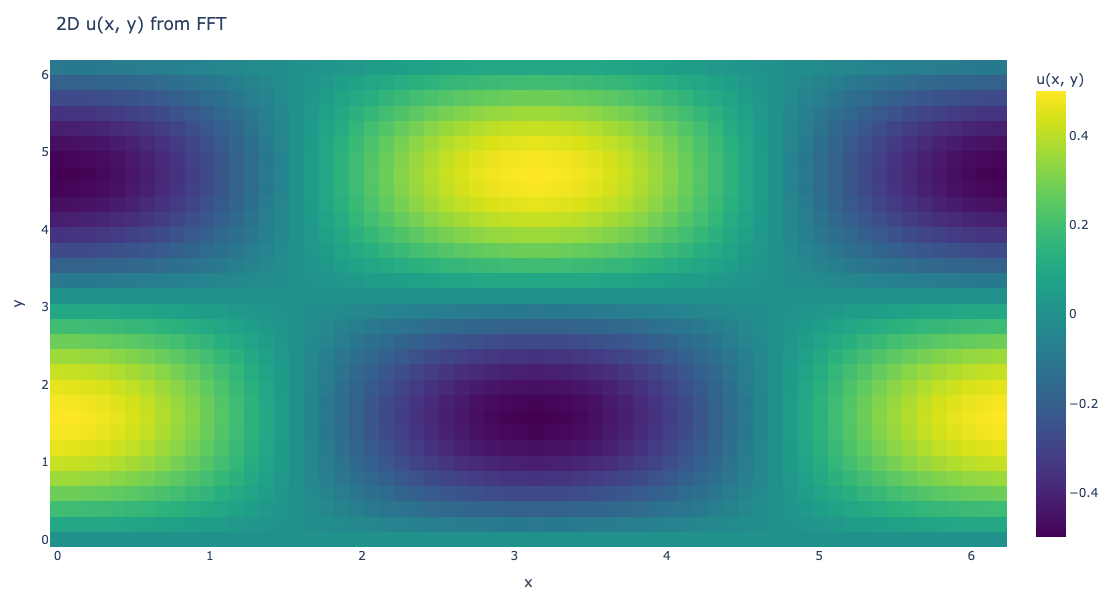

In [19]:
plot(heatmap(
    x = x,              # x-grid
    y = y,              # y-grid
    z = u_real',        
    colorscale = "Viridis",
    colorbar_title = "u(x, y)"
    ),
    Layout(
    title = "2D u(x, y) from FFT",
    xaxis_title = "x",
    yaxis_title = "y",
    width = 700,
    height = 600
    )
)

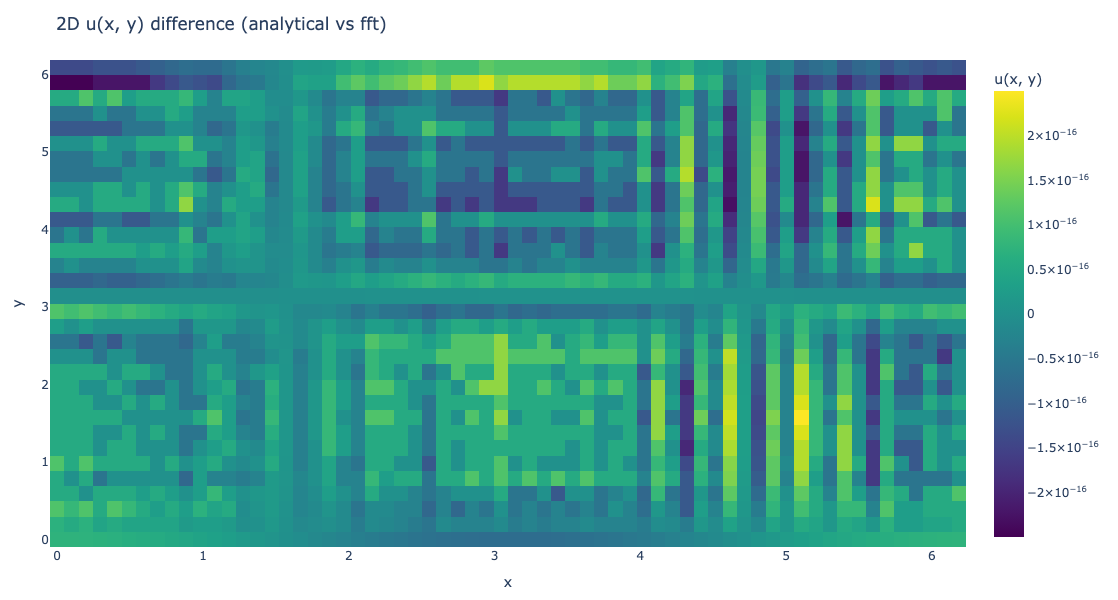

In [22]:
plot(heatmap(
    x = x,              # x-grid
    y = y,              # y-grid
    z = 0.5 * f_rhs' - u_real',        
    colorscale = "Viridis",
    colorbar_title = "u(x, y)"
), Layout(
    title = "2D u(x, y) difference (analytical vs fft) ",
    xaxis_title = "x",
    yaxis_title = "y",
    width = 700,
    height = 600
))

For non periodic boundary conditions, 2D DCT and 2D DST may be perfoemd using this same approach.